# Introduction
* OSPF was developped as a replacement of RIP
* Oepn source - Interior Gateway - Link state - routing protocol uses Dijkstra's SPF algorithm underneath.
* V1: RFC 1131 (experiemention only), V2: RFC 1247 (implements TOS routing but never widely used), 2328 (IPv4) (removed TOS). 
* __Advantages__
    1. Fast reconvergence, scalability and immune to bad routes 
    2. __Areas__ reduces cpu and memory usage 
    3. __Classess__ to support VLSM, route summary 
    4. __Arbitrary metric__ Cisco's implementation uses _Bandwidth_ and _Delay_
    5. __Equal Cost Load Balaning__ over a multiple paths
    6. __Multicast address__ to reduce impact on non-OSPF speaking nodes 
    6. __Authentication__ based on md5
    7. __Route tagging__ for tackling external routes '
* __OSPF Operations__
    1. two or more OSPF speacking routers sharing a common data link are called neighbours if they share some parameters, advertised over __hello__ packets. 
    2. __Adjacencies__ are virtual point-to-point link between __OSPF-neighbours__ defined by various _OSPF network types_
    3. network link states are advertised between adjacencies using __Link state Advertisement (LSA)__ 
    4. Each router build identiacal __Link State Database (LSDB)__ by accumulating LSAs. 
    5. __SPF__ finds best routes using __SPF Tree__ and populates routing tabe

# OSPF Process
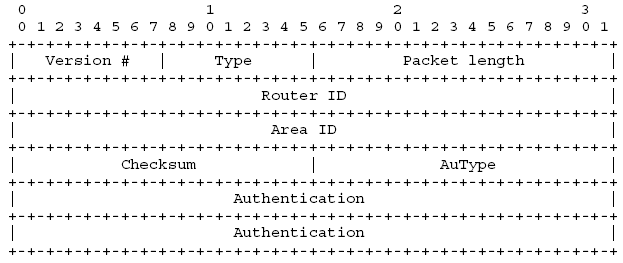

## Step 1 : Neighbourship 
__Hello__ protocol is fired as soon as the OSPF process starts 
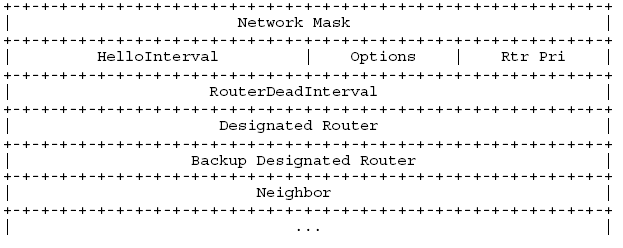
* usage of Hello
    1. neighbour discovary 
    2. parameter matching (Subnet mask, Area ID, Password, Timers, Option) __SAPTO__ 
    3. keep alive 
    4. bidirectional communication 
    5. DR/BDR election (only for broadcast and NBMA networks) 
* Hello/dead interval 
    * Hello : 10 sec for broadcast and 30 sec for non-boradcast: `(int)#ip ospf hello-interval VAL`
    * Dead : 3 times hello : `(int)#ip ospf dead-interval VAL`
* Router ID
    * presidence : manual router id `(router)# router-id ID` > max active loopback IP > max active interface IP  
    * Ecery hello packet includes its router ID, and neighbours' RID. When a router sees its own RID a receiving Hello, __2-way communication__ is eshtablished.  
* Neighbourship doesn't gurantee adjacency, that depends on the __network type__, which are.
    1. __point-to-point__ : T1, DS3, SONET etc. advertisements uses 225.0.0.5 address only
    2. __Broadcast__: Ethernet, FDDI etc. uses 224.0.0.5, 224.0.0.6 
    3. __NBMA__ : Frame-relay, ATM etc. 
    4. __point-to-multipoint__ : Special class of NBMA 
    5. __virtual-link__ : all OSPF router bust be connected to backbone aria, if not then it must make a virtual link to do so. 
    6. __loopback__ : loop back interfaces with CIDR /24

## DR/BDR election
* for a full-mesh topology of receiving LSA, there would be $\frac{n(n-1)}{2}$ copies of LSAs. To limit this, DR/BDR concept is intoduced that turns the __mesh topology into a tree__ limitting only $n-1$ packet exchange 
* the main concept of DR comes from the _pseudonode_ representation of broadcast link in SPF. link cost from any node to a pseudonode is considered but not the other way round, thus the link cost is rightly calculated. 
* DR is a per-interface property not per-router 
* Election process
    1. each router has a router-priority $\in[0,255]$ and default=0. Router with $prio\ge1$ can take part in election process. `(int)# ip ospf priority PRIO`
    2. each router sets __DR = 0.0.0.0__ at begining untill __dead time__ then set itself as DR. 
    3. compare all DRs and choose the max one. 

## OSPF tables and attributes

__Neighbour table__

| Fields       | Description |
| ---          | ---         |
| Neighbour ID |             |
| Neighbour IP |             |
| Area ID      |             |
| Interface    |             |
| Neighbor prio|             |
| state        |             |
| DR           |             |
| BDR          |             |
| Poll interval|             |

```
sh ip ospf neighbor 

Neighbor ID     Pri   State           Dead Time   Address         Interface
192.168.3.1       1   FULL/BDR        00:00:39    13.0.0.3        FastEthernet0/1
192.168.2.1       1   FULL/BDR        00:00:31    12.0.0.2        FastEthernet0/0

```
__LSDB__ 
```
sh ip ospf database 

            OSPF Router with ID (192.168.1.1) (Process ID 1)

                Router Link States (Area 0)

Link ID         ADV Router      Age         Seq#       Checksum Link count
192.168.1.1     192.168.1.1     1268        0x80000006 0x006F25 3
192.168.2.1     192.168.2.1     1233        0x80000004 0x006616 3
192.168.3.1     192.168.3.1     1087        0x80000004 0x00DC98 3

                Net Link States (Area 0)

Link ID         ADV Router      Age         Seq#       Checksum
12.0.0.1        192.168.1.1     1268        0x80000002 0x00D315
13.0.0.1        192.168.1.1     1268        0x80000002 0x00D313
23.0.0.2        192.168.2.1     1233        0x80000002 0x004990

```
__Routing Table__
```
sh ip route ospf 

     23.0.0.0/24 is subnetted, 1 subnets
O       23.0.0.0 [110/2] via 13.0.0.3, 00:52:13, FastEthernet0/1
                 [110/2] via 12.0.0.2, 00:52:13, FastEthernet0/0
     192.168.2.0/32 is subnetted, 1 subnets
O       192.168.2.1 [110/2] via 12.0.0.2, 00:52:13, FastEthernet0/0
     192.168.3.0/32 is subnetted, 1 subnets
O       192.168.3.1 [110/2] via 13.0.0.3, 00:52:13, FastEthernet0/1


```
__Interface Data structure__

| iface ID | IP addr | mask | Area ID | Process ID | Router ID | Network Type | Cost |
|---       | ----    | ---  | ---     | ---        | ---       | ---          | ---  |

```
sh ip ospf interface brief 

Interface    PID   Area            IP Address/Mask    Cost  State Nbrs F/C
Lo0          1     0               192.168.1.1/24     1     LOOP  0/0
Fa0/1        1     0               13.0.0.1/24        1     DR    1/1
Fa0/0        1     0               12.0.0.1/24        1     DR    1/1

```